In [1]:
%matplotlib inline
import radical.analytics as ra
import radical.pilot as rp
import radical.utils as ru
import radical.entk as re

from glob import glob
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
import csv
import pandas as pd
import json
from scipy.optimize import curve_fit
from scipy import stats
from pprint import pprint
from sklearn.metrics import r2_score
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.unicode'] = True

blues = cm.get_cmap(plt.get_cmap('Blues'))
greens = cm.get_cmap(plt.get_cmap('Greens'))
reds = cm.get_cmap(plt.get_cmap('Reds'))
oranges = cm.get_cmap(plt.get_cmap('Oranges'))
purples = cm.get_cmap(plt.get_cmap('Purples'))
greys = cm.get_cmap(plt.get_cmap('Greys'))

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')
!radical-stack


  python               : 2.7.16
  pythonpath           : 
  virtualenv           : radical.analytics

  radical.analytics    : v0.50.0-10-g76b5950@devel
  radical.entk         : 0.7.8
  radical.pilot        : 0.50.16
  radical.utils        : 0.50.2
  saga                 : 0.50.0



In [2]:
def utilization(timestamps,util='cpu'):
    
    tile_ids = ['Tile1','Tile2','Tile3','Tile4','Tile5','Tile6','Tile7','Tile8','Tile9','Tile10','Tile11','Tile12']
    pred_ids = ['Pred1','Pred2','Pred3','Pred4','Pred5','Pred6','Pred7','Pred8']
    cpu_times = list()
    gpu_times = list()
    cpu_counts = 0
    gpu_counts = 0
    for index,row in timestamps.iterrows():
        if (row['Type'] in tile_ids) and util =='cpu':
            cpu_counts += 1
            cpu_times.append(row['Start'])
            cpu_times.append(row['End'])
        if (row['Type'] in pred_ids) and util =='gpu':
            gpu_counts += 1
            gpu_times.append(row['Start'])
            gpu_times.append(row['End'])
    
    cpu_times.sort()
    gpu_times.sort()
    print 'Times sorted', cpu_counts, len(cpu_times)
    print gpu_counts
    cpu_util = list()
    if util == 'cpu':
        for t in cpu_times:
            cnt = 0
            for index,row in timestamps.iterrows():
                if row['Type'] in tile_ids:
                    if t >= row['Start'] and t <= row['End']:
                        cnt += 1

            cpu_util.append([t, cnt])
        print 'Cpu ready'
        return cpu_util
    
    if util == 'gpu':
        gpu_util = list()
        for t in gpu_times:
            cnt = 0
            for index,row in timestamps.iterrows():
                if row['Type'] in pred_ids:
                    if t >= row['Start'] and t <= row['End']:
                        cnt += 1

            gpu_util.append([t, cnt])
        return gpu_util
        
    return None

In [3]:
sid='../Data/Design3Dist2'
rp_session = ra.Session(stype='radical.pilot',src=sid)
units = rp_session.filter(etype='unit', inplace=False)
units_duration = units.duration(event=[{ru.EVENT: 'exec_start'},{ru.EVENT: 'exec_stop'}])


In [4]:
print 'Time to Execution:', units_duration, 'seconds or', units_duration/60.0, 'minutes or ', units_duration/60.0/60.0, 'hours'

Time to Execution: 59432.5597 seconds or 990.542661667 minutes or  16.5090443611 hours


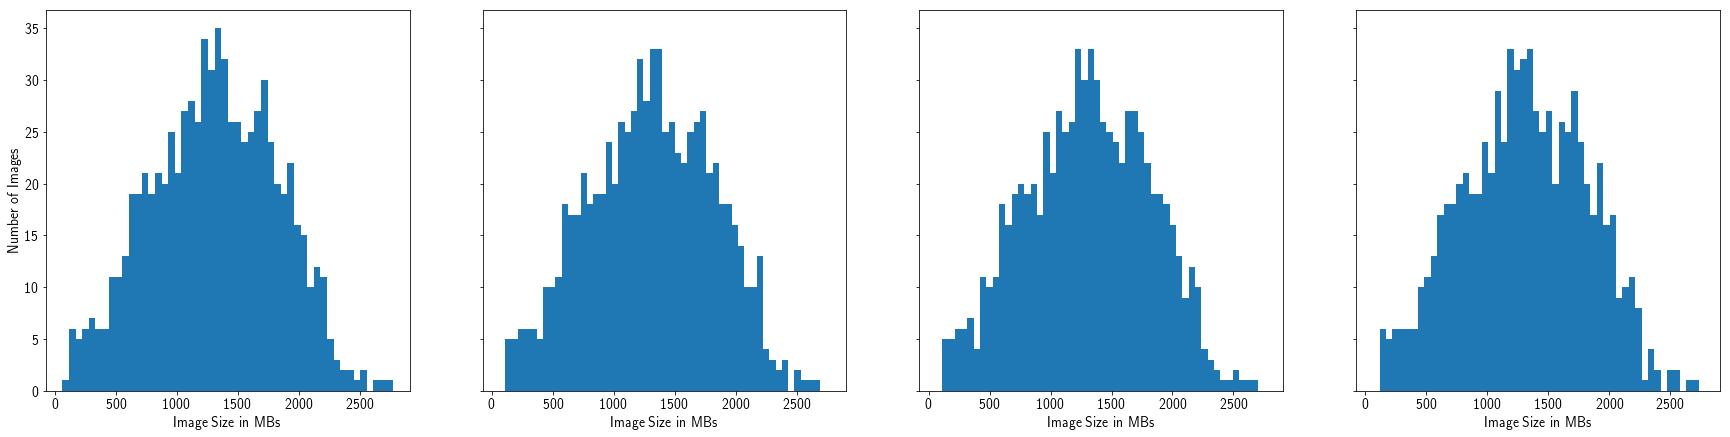

In [5]:
images = pd.DataFrame(columns=['Filename','Size'])

nodes_assignments = ['../Data/Design3Dist2/pilot.0000/unit.000000/node1_images.csv',
                     '../Data/Design3Dist2/pilot.0000/unit.000001/node2_images.csv',
                     '../Data/Design3Dist2/pilot.0000/unit.000002/node3_images.csv',
                     '../Data/Design3Dist2/pilot.0000/unit.000003/node4_images.csv']
fig, axis = plt.subplots(nrows=1,ncols=4,figsize=(30,7), sharey=True, sharex=True)
for i in range(4):
    node_images = pd.read_csv(nodes_assignments[i])
    axis[i].hist(node_images['Size'].values.tolist(), bins=50)
    axis[i].set_xlabel('Image Size in MBs', fontsize=14)
    axis[i].set_xticklabels(axis[i].get_xticks().astype('int').tolist(),fontsize=14)
    images = images.append(node_images)

_ = axis[0].set_yticklabels(axis[0].get_yticks().astype('int').tolist(),fontsize=14)
_ = axis[0].set_ylabel('Number of Images',fontsize=14)
images.reset_index(inplace=True, drop='index')

In [6]:
Tilling = pd.DataFrame(columns=['Size','Time'])

tilling = glob('../Data/Design3Dist2/pilot.0000/unit.*/tilling*csv')
for filename in tilling:
    des1tilling = pd.read_csv(filename)
    for index, row in des1tilling.iterrows():
        size = int(images.loc[images['Filename'] == row['Image']]['Size'].values[0])
        time = row['End'] - row['Start']
        Tilling.loc[len(Tilling)] = [size, time]
Tilling.sort_values(by='Size',inplace=True)
Tilling.reset_index(drop='index',inplace=True)

Des3TillingBinned = pd.DataFrame(columns=['Bin','SizeArray','SizeMean','SizeStd','SizeMin','SizeMax','TimeArray','TimeMean','TimeStd','TimeMin','TimeMax'])
for i in range(50,2800,125):
    Des3TillingBinned.loc[len(Des3TillingBinned)] = [[i, i + 125],Tilling[(i < Tilling['Size']) & (Tilling['Size']< (i + 125))]['Size'].values,
                                                                  Tilling[(i < Tilling['Size']) & (Tilling['Size']< (i + 125))]['Size'].values.mean(),
                                                                  Tilling[(i < Tilling['Size']) & (Tilling['Size']< (i + 125))]['Size'].values.std(),
                                                                  Tilling[(i < Tilling['Size']) & (Tilling['Size']< (i + 125))]['Size'].values.min(),
                                                                  Tilling[(i < Tilling['Size']) & (Tilling['Size']< (i + 125))]['Size'].values.max(),
                                                                  Tilling[(i < Tilling['Size']) & (Tilling['Size']< (i + 125))]['Time'].values,
                                                                  Tilling[(i < Tilling['Size']) & (Tilling['Size']< (i + 125))]['Time'].values.mean(),
                                                                  Tilling[(i < Tilling['Size']) & (Tilling['Size']< (i + 125))]['Time'].values.std(),
                                                                  Tilling[(i < Tilling['Size']) & (Tilling['Size']< (i + 125))]['Time'].values.min(),
                                                                  Tilling[(i < Tilling['Size']) & (Tilling['Size']< (i + 125))]['Time'].values.max()]

In [7]:
Node1Tilling = pd.DataFrame(columns=['Size','Time'])
tilling = glob('../Data/Design3Dist2/pilot.0000/unit.000000/tilling*csv')
for filename in tilling:
    des1tilling = pd.read_csv(filename)
    for index, row in des1tilling.iterrows():
        size = int(images.loc[images['Filename'] == row['Image']]['Size'].values[0])
        time = row['End'] - row['Start']
        Node1Tilling.loc[len(Node1Tilling)] = [size, time]
        
Node2Tilling = pd.DataFrame(columns=['Size','Time'])
tilling = glob('../Data/Design3Dist2/pilot.0000/unit.000001/tilling*csv')
for filename in tilling:
    des1tilling = pd.read_csv(filename)
    for index, row in des1tilling.iterrows():
        size = int(images.loc[images['Filename'] == row['Image']]['Size'].values[0])
        time = row['End'] - row['Start']
        Node2Tilling.loc[len(Node2Tilling)] = [size, time]
        
Node3Tilling = pd.DataFrame(columns=['Size','Time'])
tilling = glob('../Data/Design3Dist2/pilot.0000/unit.000002/tilling*csv')
for filename in tilling:
    des1tilling = pd.read_csv(filename)
    for index, row in des1tilling.iterrows():
        size = int(images.loc[images['Filename'] == row['Image']]['Size'].values[0])
        time = row['End'] - row['Start']
        Node3Tilling.loc[len(Node3Tilling)] = [size, time]
        
Node4Tilling = pd.DataFrame(columns=['Size','Time'])
tilling = glob('../Data/Design3Dist2/pilot.0000/unit.000003/tilling*csv')
for filename in tilling:
    des1tilling = pd.read_csv(filename)
    for index, row in des1tilling.iterrows():
        size = int(images.loc[images['Filename'] == row['Image']]['Size'].values[0])
        time = row['End'] - row['Start']
        Node4Tilling.loc[len(Node4Tilling)] = [size, time]

In [8]:
def func(x, a, b,c):
    return a*np.log10(x+b)+c

poptTilingDes3 = np.load('../Data/TillingDes3.npy')

In [9]:
Node1TillingBinned = pd.DataFrame(columns=['Bin','SizeArray','SizeMean','SizeStd','SizeMin','SizeMax','TimeArray','TimeMean','TimeStd','TimeMin','TimeMax'])
for i in range(50,2800,125):
    Node1TillingBinned.loc[len(Node1TillingBinned)] = [[i, i + 125],Node1Tilling[(i < Node1Tilling['Size']) & (Node1Tilling['Size']< (i + 125))]['Size'].values,
                                                                    Node1Tilling[(i < Node1Tilling['Size']) & (Node1Tilling['Size']< (i + 125))]['Size'].values.mean(),
                                                                    Node1Tilling[(i < Node1Tilling['Size']) & (Node1Tilling['Size']< (i + 125))]['Size'].values.std(),
                                                                    Node1Tilling[(i < Node1Tilling['Size']) & (Node1Tilling['Size']< (i + 125))]['Size'].values.min(),
                                                                    Node1Tilling[(i < Node1Tilling['Size']) & (Node1Tilling['Size']< (i + 125))]['Size'].values.max(),
                                                                    Node1Tilling[(i < Node1Tilling['Size']) & (Node1Tilling['Size']< (i + 125))]['Time'].values,
                                                                    Node1Tilling[(i < Node1Tilling['Size']) & (Node1Tilling['Size']< (i + 125))]['Time'].values.mean(),
                                                                    Node1Tilling[(i < Node1Tilling['Size']) & (Node1Tilling['Size']< (i + 125))]['Time'].values.std(),
                                                                    Node1Tilling[(i < Node1Tilling['Size']) & (Node1Tilling['Size']< (i + 125))]['Time'].values.min(),
                                                                    Node1Tilling[(i < Node1Tilling['Size']) & (Node1Tilling['Size']< (i + 125))]['Time'].values.max()]

Node2TillingBinned = pd.DataFrame(columns=['Bin','SizeArray','SizeMean','SizeStd','SizeMin','SizeMax','TimeArray','TimeMean','TimeStd','TimeMin','TimeMax'])
for i in range(50,2800,125):
    Node2TillingBinned.loc[len(Node2TillingBinned)] = [[i, i + 125],Node2Tilling[(i < Node2Tilling['Size']) & (Node2Tilling['Size']< (i + 125))]['Size'].values,
                                                                    Node2Tilling[(i < Node2Tilling['Size']) & (Node2Tilling['Size']< (i + 125))]['Size'].values.mean(),
                                                                    Node2Tilling[(i < Node2Tilling['Size']) & (Node2Tilling['Size']< (i + 125))]['Size'].values.std(),
                                                                    Node2Tilling[(i < Node2Tilling['Size']) & (Node2Tilling['Size']< (i + 125))]['Size'].values.min(),
                                                                    Node2Tilling[(i < Node2Tilling['Size']) & (Node2Tilling['Size']< (i + 125))]['Size'].values.max(),
                                                                    Node2Tilling[(i < Node2Tilling['Size']) & (Node2Tilling['Size']< (i + 125))]['Time'].values,
                                                                    Node2Tilling[(i < Node2Tilling['Size']) & (Node2Tilling['Size']< (i + 125))]['Time'].values.mean(),
                                                                    Node2Tilling[(i < Node2Tilling['Size']) & (Node2Tilling['Size']< (i + 125))]['Time'].values.std(),
                                                                    Node2Tilling[(i < Node2Tilling['Size']) & (Node2Tilling['Size']< (i + 125))]['Time'].values.min(),
                                                                    Node2Tilling[(i < Node2Tilling['Size']) & (Node2Tilling['Size']< (i + 125))]['Time'].values.max()]

Node3TillingBinned = pd.DataFrame(columns=['Bin','SizeArray','SizeMean','SizeStd','SizeMin','SizeMax','TimeArray','TimeMean','TimeStd','TimeMin','TimeMax'])
for i in range(50,2800,125):
    Node3TillingBinned.loc[len(Node3TillingBinned)] = [[i, i + 125],Node3Tilling[(i < Node3Tilling['Size']) & (Node3Tilling['Size']< (i + 125))]['Size'].values,
                                                                    Node3Tilling[(i < Node3Tilling['Size']) & (Node3Tilling['Size']< (i + 125))]['Size'].values.mean(),
                                                                    Node3Tilling[(i < Node3Tilling['Size']) & (Node3Tilling['Size']< (i + 125))]['Size'].values.std(),
                                                                    Node3Tilling[(i < Node3Tilling['Size']) & (Node3Tilling['Size']< (i + 125))]['Size'].values.min(),
                                                                    Node3Tilling[(i < Node3Tilling['Size']) & (Node3Tilling['Size']< (i + 125))]['Size'].values.max(),
                                                                    Node3Tilling[(i < Node3Tilling['Size']) & (Node3Tilling['Size']< (i + 125))]['Time'].values,
                                                                    Node3Tilling[(i < Node3Tilling['Size']) & (Node3Tilling['Size']< (i + 125))]['Time'].values.mean(),
                                                                    Node3Tilling[(i < Node3Tilling['Size']) & (Node3Tilling['Size']< (i + 125))]['Time'].values.std(),
                                                                    Node3Tilling[(i < Node3Tilling['Size']) & (Node3Tilling['Size']< (i + 125))]['Time'].values.min(),
                                                                    Node3Tilling[(i < Node3Tilling['Size']) & (Node3Tilling['Size']< (i + 125))]['Time'].values.max()]

Node4TillingBinned = pd.DataFrame(columns=['Bin','SizeArray','SizeMean','SizeStd','SizeMin','SizeMax','TimeArray','TimeMean','TimeStd','TimeMin','TimeMax'])
for i in range(50,2800,125):
    Node4TillingBinned.loc[len(Node4TillingBinned)] = [[i, i + 125],Node4Tilling[(i < Node4Tilling['Size']) & (Node4Tilling['Size']< (i + 125))]['Size'].values,
                                                                    Node4Tilling[(i < Node4Tilling['Size']) & (Node4Tilling['Size']< (i + 125))]['Size'].values.mean(),
                                                                    Node4Tilling[(i < Node4Tilling['Size']) & (Node4Tilling['Size']< (i + 125))]['Size'].values.std(),
                                                                    Node4Tilling[(i < Node4Tilling['Size']) & (Node4Tilling['Size']< (i + 125))]['Size'].values.min(),
                                                                    Node4Tilling[(i < Node4Tilling['Size']) & (Node4Tilling['Size']< (i + 125))]['Size'].values.max(),
                                                                    Node4Tilling[(i < Node4Tilling['Size']) & (Node4Tilling['Size']< (i + 125))]['Time'].values,
                                                                    Node4Tilling[(i < Node4Tilling['Size']) & (Node4Tilling['Size']< (i + 125))]['Time'].values.mean(),
                                                                    Node4Tilling[(i < Node4Tilling['Size']) & (Node4Tilling['Size']< (i + 125))]['Time'].values.std(),
                                                                    Node4Tilling[(i < Node4Tilling['Size']) & (Node4Tilling['Size']< (i + 125))]['Time'].values.min(),
                                                                    Node4Tilling[(i < Node4Tilling['Size']) & (Node4Tilling['Size']< (i + 125))]['Time'].values.max()]

Node 1 Logarithmic: R-squared -3.4742686653917403 Standard Error of the Estimation:  52.65988314206529
Design 3 Stage 1 Node 1 TTX summation: 64691.2020111084 Predicted TTX summation:  102018.30085270046
Node 1 Logarithmic: R-squared -2.6538391276284803 Standard Error of the Estimation:  51.5552972960109
Design 3 Stage 1 Node 1 TTX summation: 65548.2312374115 Predicted TTX summation:  101868.83397949589
Node 1 Logarithmic: R-squared 0.037100802980930214 Standard Error of the Estimation:  233.98288844887665
Design 3 Stage 1 Node 1 TTX summation: 159584.02106642723 Predicted TTX summation:  101906.45720482687
Node 1 Logarithmic: R-squared -3.5844931383518865 Standard Error of the Estimation:  51.68359105643583
Design 3 Stage 1 Node 1 TTX summation: 65378.11245536804 Predicted TTX summation:  101942.66501080286


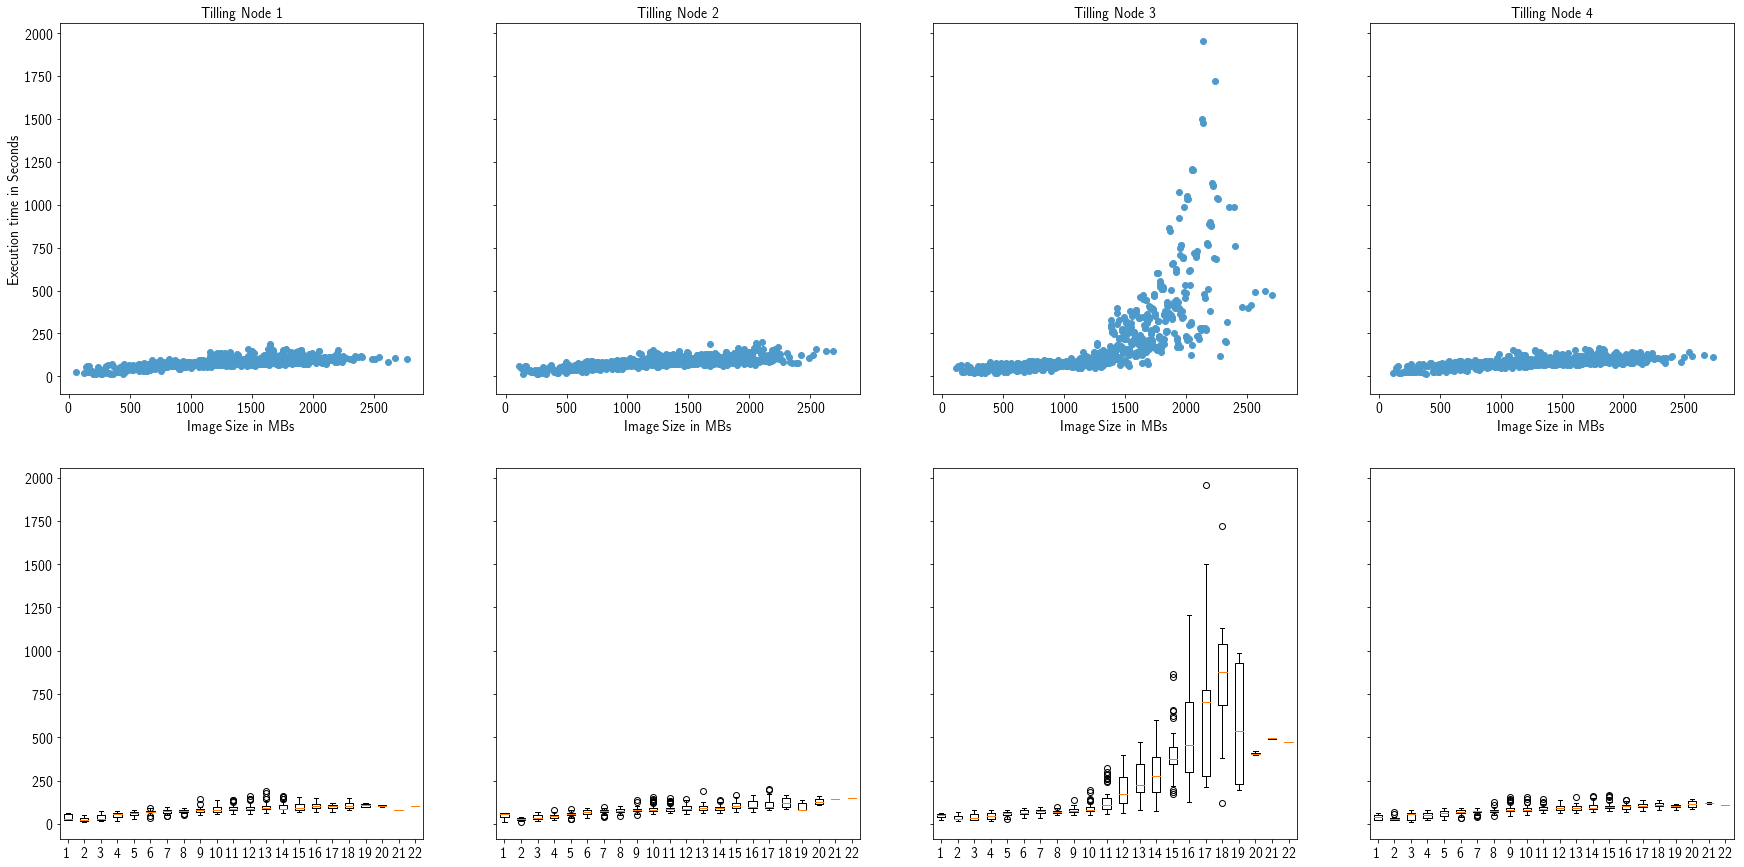

In [13]:
fig, axis = plt.subplots(nrows=2, ncols=4, figsize=(30, 15), sharey='row', sharex='row')
_ = axis[0,0].scatter(Node1Tilling['Size'].values, Node1Tilling['Time'].values, color=blues(150))
_ = axis[0,1].scatter(Node2Tilling['Size'].values, Node2Tilling['Time'].values, color=blues(150))
_ = axis[0,2].scatter(Node3Tilling['Size'].values, Node3Tilling['Time'].values, color=blues(150))
_ = axis[0,3].scatter(Node4Tilling['Size'].values, Node4Tilling['Time'].values, color=blues(150))
for i in range(4):
    _ = axis[0,i].set_xlabel('Image Size in MBs', fontsize=14)
    _ = axis[0,i].set_xticklabels(axis[0,i].get_xticks().astype('int').tolist(),fontsize=14)
    _ = axis[0,i].set_yticklabels(axis[0,i].get_yticks().astype('int').tolist(),fontsize=14)
    _ = axis[0,i].set_title('Tilling Node %d' % (i + 1), fontsize=14)

_ = axis[0,0].set_ylabel('Execution time in Seconds',fontsize=14)

_ = axis[1,0].boxplot(Node1TillingBinned['TimeArray'].values)
_ = axis[1,1].boxplot(Node2TillingBinned['TimeArray'].values)
_ = axis[1,2].boxplot(Node3TillingBinned['TimeArray'].values)
_ = axis[1,3].boxplot(Node4TillingBinned['TimeArray'].values)

for i in range(4):
    _ = axis[1,i].set_xticklabels(axis[1,i].get_xticks().astype('int').tolist(),fontsize=14)
    _ = axis[1,i].set_yticklabels(axis[1,i].get_yticks().astype('int').tolist(),fontsize=14)
    
TillingPredDes3Node1 = func(Node1Tilling['Size'].values, *poptTilingDes3)
s1 = np.sqrt(np.sum(np.power((Node1Tilling['Time'].values - TillingPredDes3Node1), 2))/(len(Node1Tilling['Time'].values)-3))
TillingPredDes3Node2 = func(Node2Tilling['Size'].values, *poptTilingDes3)
s2 = np.sqrt(np.sum(np.power((Node2Tilling['Time'].values - TillingPredDes3Node2), 2))/(len(Node2Tilling['Time'].values)-3))
TillingPredDes3Node3 = func(Node3Tilling['Size'].values, *poptTilingDes3)
s3 = np.sqrt(np.sum(np.power((Node3Tilling['Time'].values - TillingPredDes3Node3), 2))/(len(Node3Tilling['Time'].values)-3))
TillingPredDes3Node4 = func(Node4Tilling['Size'].values, *poptTilingDes3)
s4 = np.sqrt(np.sum(np.power((Node4Tilling['Time'].values - TillingPredDes3Node4), 2))/(len(Node4Tilling['Time'].values)-3))
print 'Node 1 Logarithmic: R-squared', r2_score(Node1Tilling['Time'].values, TillingPredDes3Node1), 'Standard Error of the Estimation: ', s1
print 'Design 3 Stage 1 Node 1 TTX summation:', Node1Tilling['Time'].values.sum(), 'Predicted TTX summation: ', TillingPredDes3Node1.sum()
print 'Node 1 Logarithmic: R-squared', r2_score(Node2Tilling['Time'].values, TillingPredDes3Node2), 'Standard Error of the Estimation: ', s2
print 'Design 3 Stage 1 Node 1 TTX summation:', Node2Tilling['Time'].values.sum(), 'Predicted TTX summation: ', TillingPredDes3Node2.sum()
print 'Node 1 Logarithmic: R-squared', r2_score(Node3Tilling['Time'].values, TillingPredDes3Node3), 'Standard Error of the Estimation: ', s3
print 'Design 3 Stage 1 Node 1 TTX summation:', Node3Tilling['Time'].values.sum(), 'Predicted TTX summation: ', TillingPredDes3Node3.sum()
print 'Node 1 Logarithmic: R-squared', r2_score(Node4Tilling['Time'].values, TillingPredDes3Node4), 'Standard Error of the Estimation: ', s4
print 'Design 3 Stage 1 Node 1 TTX summation:', Node4Tilling['Time'].values.sum(), 'Predicted TTX summation: ', TillingPredDes3Node4.sum()


In [ ]:

xdata = Tilling['Size'].values
ydata = Tilling['Time'].values
x = np.array(range(50,2950,50))
y = func(x, *poptTilingDes3)

fig,axis = plt.subplots(nrows=1,ncols=2,figsize=(25,7),sharey='row')
_ = axis[0].scatter(xdata,ydata,color=blues(150),label="Task Execution Time")
_ = axis[0].plot(x, y, 'r-', label="Fitted Logarithmic Curve")
_ = axis[0].set_ylabel('Execution Time in seconds',fontsize=14)
_ = axis[0].set_xlabel('Image Size in MBs',fontsize=14)
_ = axis[0].set_xticks(np.array(range(50,3050,125)))
_ = axis[0].set_xticklabels(axis[0].get_xticks().astype('int').tolist(),fontsize=14, rotation=45)
_ = axis[0].set_yticklabels(axis[0].get_yticks().astype('int').tolist(),fontsize=14)
_ = axis[0].grid('on')
_ = axis[0].legend(fontsize=14)    
_ = axis[1].boxplot(Des3TillingBinned['TimeArray'].values)
x = Des3TillingBinned['SizeMean'].values
y = func(x, *poptTilingDes3)
s1 = np.sqrt(np.sum(np.power((Des3TillingBinned['TimeMean'].values - y), 2))/(len(y)-3))
_ = axis[1].errorbar(range(1,23),Des3TillingBinned['TimeMean'].values,yerr=Des3TillingBinned['TimeStd'].values,marker='o',label='Mean Execution Time')
_ = axis[1].plot(range(1,23), y, 'r-', label="Fitted Logarithmic Curve")
_ = axis[1].fill_between(range(1,23),y - s1, y + s1, color=reds(250), alpha=0.2)
_ = axis[1].set_ylabel('Execution Time in seconds',fontsize=14)
_ = axis[1].set_xlabel('Bin Index',fontsize=14)
_ = axis[1].set_xticklabels(axis[1].get_xticks().astype('int').tolist(),fontsize=14, rotation=45)
_ = axis[1].set_yticklabels(axis[1].get_yticks().astype('int').tolist(),fontsize=14)
_ = axis[1].grid('on')
_ = axis[1].legend(fontsize=14)

TillingPredDes3 = func(xdata, *poptTilingDes3)
print 'Logarithmic: R-squared', r2_score(Des3TillingBinned['TimeMean'].values,y), 'Standard Error of the Estimation: ', s1
print 'Design 3 Stage 1 TTX summation:', ydata.sum(), 'Predicted TTX summation: ', TillingPredDes3.sum()
#fig.savefig('stage_0_execution_time.pdf',dpi=800,bbox_inches='tight')

In [ ]:
Pred = pd.DataFrame(columns=['Size','Time'])

pred_files = glob('Design3Dist2/pilot.0000/unit.*/pred*csv')
for filename in pred_files:
    des1pred = pd.read_csv(filename)
    for index, row in des1pred.iterrows():
        size = int(images.loc[images['Filename'] == '/pylon5/mc3bggp/bspitz/Seals/' + row['Image'] + '.tif']['Size'].values[0])
        time = row['End'] - row['Start']
        Pred.loc[len(Pred)] = [size, time]
Pred.sort_values(by='Size',inplace=True)
Pred.reset_index(drop='index',inplace=True)

Des3PredBinned = pd.DataFrame(columns=['Bin','SizeArray','SizeMean','SizeStd','SizeMin','SizeMax','TimeArray','TimeMean','TimeStd','TimeMin','TimeMax'])
for i in range(50,2800,125):
    Des3PredBinned.loc[len(Des3PredBinned)] = [[i, i + 125],Pred[(i < Pred['Size']) & (Pred['Size']< (i + 125))]['Size'].values,
                                                            Pred[(i < Pred['Size']) & (Pred['Size']< (i + 125))]['Size'].values.mean(),
                                                            Pred[(i < Pred['Size']) & (Pred['Size']< (i + 125))]['Size'].values.std(),
                                                            Pred[(i < Pred['Size']) & (Pred['Size']< (i + 125))]['Size'].values.min(),
                                                            Pred[(i < Pred['Size']) & (Pred['Size']< (i + 125))]['Size'].values.max(),
                                                            Pred[(i < Pred['Size']) & (Pred['Size']< (i + 125))]['Time'].values,
                                                            Pred[(i < Pred['Size']) & (Pred['Size']< (i + 125))]['Time'].values.mean(),
                                                            Pred[(i < Pred['Size']) & (Pred['Size']< (i + 125))]['Time'].values.std(),
                                                            Pred[(i < Pred['Size']) & (Pred['Size']< (i + 125))]['Time'].values.min(),
                                                            Pred[(i < Pred['Size']) & (Pred['Size']< (i + 125))]['Time'].values.max()]

In [ ]:
def func(x, a, b):
    return a*x+b

xdata = Pred['Size'].values
ydata = Pred['Time'].values
poptPredDes3 = np.load('PredDes3.npy')
x = np.array(range(50,2950,50))
y = func(x, *poptPredDes3)


In [ ]:
fig, axis = plt.subplots(nrows=1, ncols=2, figsize=(25,7), sharey='row')
_ = axis[0].scatter(xdata, ydata, color=blues(150), label="Task Execution Time")
_ = axis[0].plot(x, y, 'r-', label="Fitted Linear Curve")
_ = axis[0].set_ylabel('Execution Time in seconds',fontsize=14)
_ = axis[0].set_xlabel('Image Size in MBs',fontsize=14)
_ = axis[0].set_xticks(np.array(range(50,3050,125)))
_ = axis[0].set_xticklabels(axis[0].get_xticks().astype('int').tolist(),fontsize=14, rotation=45)
_ = axis[0].set_yticklabels(axis[0].get_yticks().astype('int').tolist(),fontsize=14)
_ = axis[0].grid('on')
_ = axis[0].legend(fontsize=14)
x = Des3PredBinned['SizeMean'].values
y = func(x, *poptPredDes3)
s1 = np.sqrt(np.sum(np.power((Des3PredBinned['TimeMean'].values - y), 2))/(len(y)-2))
_ = axis[1].boxplot(Des3PredBinned['TimeArray'].values)
_ = axis[1].errorbar(range(1,23),Des3PredBinned['TimeMean'].values,yerr=Des3PredBinned['TimeStd'].values,marker='o',label='Mean Execution Time')
_ = axis[1].plot(range(1,23), y, 'r-', label="Fitted Linear Curve")
_ = axis[1].fill_between(range(1,23),y - s1, y + s1, color=reds(250), alpha=0.2)
_ = axis[1].set_ylabel('Execution Time in seconds',fontsize=14)
_ = axis[1].set_xlabel('Bin Index',fontsize=14)
_ = axis[1].set_xticklabels(axis[1].get_xticks().astype('int').tolist(),fontsize=14, rotation=45)
_ = axis[1].set_yticklabels(axis[1].get_yticks().astype('int').tolist(),fontsize=14)
_ = axis[1].grid('on')
_ = axis[1].legend(fontsize=14)

PredPredDes3 = func(xdata, *poptPredDes3)
print 'Logarithmic: R-squared', r2_score(Des3PredBinned['TimeMean'].values,y), 'Standard Error of the Estimation: ', s1
print 'Design 3 Stage 1 TTX summation:', ydata.sum(), 'Predicted TTX summation: ', PredPredDes3.sum()
#fig.savefig('stage_0_execution_time.pdf',dpi=800,bbox_inches='tight')

In [ ]:
fig, axis = plt.subplots(nrows=1,ncols=4,figsize=(30,7), sharey=True, sharex=True)
for i in range(4):
    tiled_csvs = glob('Design3Dist2/pilot.0000/unit.%06d/tilling*.csv' % i)
    tiles = list()
    for filename in tiled_csvs:
        des1tilled = pd.read_csv(filename)
        tiles += des1tilled['Tiles'].values.tolist()
    axis[i].hist(tiles, bins=50, color=blues(150))
    axis[i].set_xlabel('Number of Tiles', fontsize=14)
    axis[i].set_xticklabels(axis[i].get_xticks().astype('int').tolist(),fontsize=14)

_ = axis[0].set_yticklabels(axis[0].get_xticks().astype('int').tolist(),fontsize=14)
_ = axis[0].set_ylabel('Number of Images',fontsize=14)
    

In [ ]:
fig, axis = plt.subplots(nrows=1,ncols=4,figsize=(30,7), sharey=True, sharex=True)
for i in range(4):
    tiled_csvs = glob('Design3Dist2/pilot.0000/unit.%06d/pred*.csv' % i)
    tiles = list()
    for filename in tiled_csvs:
        des1tilled = pd.read_csv(filename)
        tiles += des1tilled['Seals'].values.tolist()
    axis[i].hist(tiles, bins=50, color=blues(150))
    axis[i].set_xlabel('Number of Seals', fontsize=14)
    axis[i].set_xticklabels(axis[i].get_xticks().astype('int').tolist(),fontsize=14)

_ = axis[0].set_yticklabels(axis[0].get_xticks().astype('int').tolist(),fontsize=14)
_ = axis[0].set_ylabel('Number of Images',fontsize=14)

In [ ]:
Node1 = pd.DataFrame(columns=['Start','End','Type'])
Node1Tilling = pd.read_csv('Design3Dist2/pilot.0000/unit.000000/tilling1.csv')
for index,row in Node1Tilling.iterrows():
    Node1.loc[len(Node1)] = [row['Start'],row['End'],'Tile1']
Node1Tilling = pd.read_csv('Design3Dist2/pilot.0000/unit.000000/tilling2.csv')
for index,row in Node1Tilling.iterrows():
    Node1.loc[len(Node1)] = [row['Start'],row['End'],'Tile2']
Node1Tilling = pd.read_csv('Design3Dist2/pilot.0000/unit.000000/tilling3.csv')
for index,row in Node1Tilling.iterrows():
    Node1.loc[len(Node1)] = [row['Start'],row['End'],'Tile3']

Node1Tilling = pd.read_csv('Design3Dist2/pilot.0000/unit.000000/pred1.csv')
for index,row in Node1Tilling.iterrows():
    Node1.loc[len(Node1)] = [row['Start'],row['End'],'Pred1']
Node1Tilling = pd.read_csv('Design3Dist2/pilot.0000/unit.000000/pred2.csv')
for index,row in Node1Tilling.iterrows():
    Node1.loc[len(Node1)] = [row['Start'],row['End'],'Pred2']

In [ ]:
Node2 = pd.DataFrame(columns=['Start','End','Type'])
Node2Tilling = pd.read_csv('Design3Dist2/pilot.0000/unit.000001/tilling09.csv')
for index,row in Node2Tilling.iterrows():
    Node2.loc[len(Node2)] = [row['Start'],row['End'],'Tile4']
Node2Tilling = pd.read_csv('Design3Dist2/pilot.0000/unit.000001/tilling10.csv')
for index,row in Node2Tilling.iterrows():
    Node2.loc[len(Node2)] = [row['Start'],row['End'],'Tile5']
Node2Tilling = pd.read_csv('Design3Dist2/pilot.0000/unit.000001/tilling11.csv')
for index,row in Node2Tilling.iterrows():
    Node2.loc[len(Node2)] = [row['Start'],row['End'],'Tile6']
Node2Tilling = pd.read_csv('Design3Dist2/pilot.0000/unit.000001/pred3.csv')
for index,row in Node2Tilling.iterrows():
    Node2.loc[len(Node2)] = [row['Start'],row['End'],'Pred3']
Node2Tilling = pd.read_csv('Design3Dist2/pilot.0000/unit.000001/pred4.csv')
for index,row in Node2Tilling.iterrows():
    Node2.loc[len(Node2)] = [row['Start'],row['End'],'Pred4']

In [ ]:
Node3 = pd.DataFrame(columns=['Start','End','Type'])
Node3Tilling = pd.read_csv('Design3Dist2/pilot.0000/unit.000002/tilling17.csv')
for index,row in Node3Tilling.iterrows():
    Node3.loc[len(Node3)] = [row['Start'],row['End'],'Tile7']
Node3Tilling = pd.read_csv('Design3Dist2/pilot.0000/unit.000002/tilling18.csv')
for index,row in Node3Tilling.iterrows():
    Node3.loc[len(Node3)] = [row['Start'],row['End'],'Tile8']
Node3Tilling = pd.read_csv('Design3Dist2/pilot.0000/unit.000002/tilling19.csv')
for index,row in Node3Tilling.iterrows():
    Node3.loc[len(Node3)] = [row['Start'],row['End'],'Tile9']
Node3Tilling = pd.read_csv('Design3Dist2/pilot.0000/unit.000002/pred5.csv')
for index,row in Node3Tilling.iterrows():
    Node3.loc[len(Node3)] = [row['Start'],row['End'],'Pred5']
Node3Tilling = pd.read_csv('Design3Dist2/pilot.0000/unit.000002/pred6.csv')
for index,row in Node3Tilling.iterrows():
    Node3.loc[len(Node3)] = [row['Start'],row['End'],'Pred6']

In [ ]:
Node4 = pd.DataFrame(columns=['Start','End','Type'])
Node4Tilling = pd.read_csv('Design3Dist2/pilot.0000/unit.000003/tilling25.csv')
for index,row in Node4Tilling.iterrows():
    Node4.loc[len(Node4)] = [row['Start'],row['End'],'Tile10']
Node4Tilling = pd.read_csv('Design3Dist2/pilot.0000/unit.000003/tilling26.csv')
for index,row in Node4Tilling.iterrows():
    Node4.loc[len(Node4)] = [row['Start'],row['End'],'Tile11']
Node4Tilling = pd.read_csv('Design3Dist2/pilot.0000/unit.000003/tilling27.csv')
for index,row in Node4Tilling.iterrows():
    Node4.loc[len(Node4)] = [row['Start'],row['End'],'Tile12']
Node4Tilling = pd.read_csv('Design3Dist2/pilot.0000/unit.000003/pred7.csv')
for index,row in Node4Tilling.iterrows():
    Node4.loc[len(Node4)] = [row['Start'],row['End'],'Pred7']
Node4Tilling = pd.read_csv('Design3Dist2/pilot.0000/unit.000003/pred8.csv')
for index,row in Node4Tilling.iterrows():
    Node4.loc[len(Node4)] = [row['Start'],row['End'],'Pred8']

In [ ]:
Design3 = Node1
Design3 = Design3.append(Node2)
Design3 = Design3.append(Node3)
Design3 = Design3.append(Node4)
Design3.reset_index(inplace=True,drop='index)')

Node1.sort_values('Start',axis=0,inplace=True)
Node1.reset_index(inplace=True,drop='index')
ZeroTime = Node1['Start'][0]
for index, row in Node1.iterrows():
    Node1.loc[index] = [row['Start'] - ZeroTime, row['End'] - ZeroTime, row['Type']]
    
Node2.sort_values('Start',axis=0,inplace=True)
Node2.reset_index(inplace=True,drop='index')
ZeroTime = Node2['Start'][0]
for index, row in Node2.iterrows():
    Node2.loc[index] = [row['Start'] - ZeroTime, row['End'] - ZeroTime, row['Type']]
    
Node3.sort_values('Start',axis=0,inplace=True)
Node3.reset_index(inplace=True,drop='index')
ZeroTime = Node3['Start'][0]
for index, row in Node3.iterrows():
    Node3.loc[index] = [row['Start'] - ZeroTime, row['End'] - ZeroTime, row['Type']]
Node4.sort_values('Start',axis=0,inplace=True)
Node4.reset_index(inplace=True,drop='index')
ZeroTime = Node4['Start'][0]
for index, row in Node4.iterrows():
    Node4.loc[index] = [row['Start'] - ZeroTime, row['End'] - ZeroTime, row['Type']]

In [ ]:
#%matplotlib notebook
fig, axis = plt.subplots(nrows=4,ncols=1,figsize=(30,16),sharex=True)
for index, row in Node1.iterrows():
    if row['Type'] == 'Tile1':
        axis[0].hlines(1, row['Start'],row['End'], colors=blues(150), lw=20)
    elif row['Type'] == 'Tile2': 
        axis[0].hlines(2, row['Start'],row['End'], colors=blues(150), lw=20)
    elif row['Type'] == 'Tile3': 
        axis[0].hlines(3, row['Start'],row['End'], colors=blues(150), lw=20)
    elif row['Type'] == 'Pred1': 
        axis[0].hlines(4, row['Start'],row['End'], colors=reds(150), lw=20)
    elif row['Type'] == 'Pred2': 
        axis[0].hlines(5, row['Start'],row['End'], colors=reds(150), lw=20)

_ = axis[0].set_yticks([1,2,3,4,5])
_ = axis[0].set_yticklabels( ['CPU 1', 'CPU 2', 'CPU 3', 'GPU 1', 'GPU 2'], fontsize=16)
for index, row in Node2.iterrows():
    if row['Type'] == 'Tile4':
        axis[1].hlines(1, row['Start'],row['End'], colors=blues(150), lw=20)
    elif row['Type'] == 'Tile5': 
        axis[1].hlines(2, row['Start'],row['End'], colors=blues(150), lw=20)
    elif row['Type'] == 'Tile6': 
        axis[1].hlines(3, row['Start'],row['End'], colors=blues(150), lw=20)
    elif row['Type'] == 'Pred3': 
        axis[1].hlines(4, row['Start'],row['End'], colors=reds(150), lw=20)
    elif row['Type'] == 'Pred4': 
        axis[1].hlines(5, row['Start'],row['End'], colors=reds(150), lw=20)

_ = axis[1].set_yticks([1,2,3,4,5])
_ = axis[1].set_yticklabels( ['CPU 1', 'CPU 2', 'CPU 3', 'GPU 1', 'GPU 2'], fontsize=16)

for index, row in Node3.iterrows():
    if row['Type'] == 'Tile7':
        axis[2].hlines(1, row['Start'],row['End'], colors=blues(150), lw=20)
    elif row['Type'] == 'Tile8': 
        axis[2].hlines(2, row['Start'],row['End'], colors=blues(150), lw=20)
    elif row['Type'] == 'Tile9': 
        axis[2].hlines(3, row['Start'],row['End'], colors=blues(150), lw=20)
    elif row['Type'] == 'Pred5': 
        axis[2].hlines(4, row['Start'],row['End'], colors=reds(150), lw=20)
    elif row['Type'] == 'Pred6': 
        axis[2].hlines(5, row['Start'],row['End'], colors=reds(150), lw=20)

_ = axis[2].set_yticks([1,2,3,4,5])
_ = axis[2].set_yticklabels( ['CPU 1', 'CPU 2', 'CPU 3', 'GPU 1', 'GPU 2'], fontsize=16)

for index, row in Node4.iterrows():
    if row['Type'] == 'Tile10':
        axis[3].hlines(1, row['Start'],row['End'], colors=blues(150), lw=20)
    elif row['Type'] == 'Tile11': 
        axis[3].hlines(2, row['Start'],row['End'], colors=blues(150), lw=20)
    elif row['Type'] == 'Tile12': 
        axis[3].hlines(3, row['Start'],row['End'], colors=blues(150), lw=20)
    elif row['Type'] == 'Pred7': 
        axis[3].hlines(4, row['Start'],row['End'], colors=reds(150), lw=20)
    elif row['Type'] == 'Pred8': 
        axis[3].hlines(5, row['Start'],row['End'], colors=reds(150), lw=20)

_ = axis[3].set_yticks([1,2,3,4,5])
_ = axis[3].set_yticklabels( ['CPU 1', 'CPU 2', 'CPU 3', 'GPU 1', 'GPU 2'], fontsize=16)

#_ = axis.set_xlabel('Time', fontsize=16)
#_ = axis.set_ylabel('Resource', fontsize=16)
#_ = axis.grid('on')

In [ ]:
fig, axis = plt.subplots(nrows=2,ncols=4,figsize=(18,8),sharex='row',sharey='row')
cpu1=cpu2=cpu3=cpu4=cpu5=cpu6=cpu7=cpu8=cpu9=cpu10=cpu11=cpu12=0
gpu1=gpu2=gpu3=gpu4=gpu5=gpu6=gpu7=gpu8=0

for index, row in Node1.iterrows():
    if row['Type'] == 'Tile1':
        cpu1 += row['End']-row['Start']
    elif row['Type'] == 'Tile2': 
        cpu2 += row['End']-row['Start']
    elif row['Type'] == 'Tile3': 
        cpu3 += row['End']-row['Start']
    elif row['Type'] == 'Pred1': 
        gpu1 += row['End']-row['Start']
    elif row['Type'] == 'Pred2': 
        gpu2 += row['End']-row['Start']
        
x1 = np.arange(1)
x2 = np.arange(1)
_ = axis[0,0].bar(x1,np.array([cpu1, cpu2, cpu3]).mean(),yerr=np.array([cpu1, cpu2, cpu3]).std(), color=blues(150))
_ = axis[0,0].bar(x2+1,np.array([gpu1, gpu2]).mean(),yerr=np.array([gpu1,gpu2]).std(), color=reds(150))
_ = axis[0,0].set_xticks([0,1])
_ = axis[0,0].grid('on')
_ = axis[0,0].set_xticklabels(['CPUs', 'GPUs'], fontsize=16)

for index, row in Node2.iterrows():
    if row['Type'] == 'Tile4':
        cpu4 += row['End']-row['Start']
    elif row['Type'] == 'Tile5': 
        cpu5 += row['End']-row['Start']
    elif row['Type'] == 'Tile6': 
        cpu6 += row['End']-row['Start']
    elif row['Type'] == 'Pred3': 
        gpu3 += row['End']-row['Start']
    elif row['Type'] == 'Pred4': 
        gpu4 += row['End']-row['Start']

x1 = np.arange(1)
x2 = np.arange(1)
_ = axis[0,1].bar(x1,np.array([cpu4, cpu5, cpu6]).mean(),yerr=np.array([cpu4, cpu5, cpu6]).std(), color=blues(150))
_ = axis[0,1].bar(x2+1,np.array([gpu3, gpu4]).mean(),yerr=np.array([gpu3,gpu4]).std(), color=reds(150))
_ = axis[0,1].set_xticks([0,1])
_ = axis[0,1].grid('on')
_ = axis[0,1].set_xticklabels(['CPUs', 'GPUs'], fontsize=16)

for index, row in Node3.iterrows():
    if row['Type'] == 'Tile7':
        cpu7 += row['End']-row['Start']
    elif row['Type'] == 'Tile8': 
        cpu8 += row['End']-row['Start']
    elif row['Type'] == 'Tile9': 
        cpu9 += row['End']-row['Start']
    elif row['Type'] == 'Pred5': 
        gpu5 += row['End']-row['Start']
    elif row['Type'] == 'Pred6': 
        gpu6 += row['End']-row['Start']

x1 = np.arange(1)
x2 = np.arange(1)
_ = axis[0,2].bar(x1,np.array([cpu7, cpu8, cpu9]).mean(),yerr=np.array([cpu7, cpu8, cpu9]).std(), color=blues(150))
_ = axis[0,2].bar(x2+1,np.array([gpu5, gpu6]).mean(),yerr=np.array([gpu5,gpu6]).std(), color=reds(150))
_ = axis[0,2].set_xticks([0,1])
_ = axis[0,2].grid('on')
_ = axis[0,2].set_xticklabels(['CPUs', 'GPUs'], fontsize=16)

for index, row in Node4.iterrows():
    if row['Type'] == 'Tile10':
        cpu10 += row['End']-row['Start']
    elif row['Type'] == 'Tile11': 
        cpu11 += row['End']-row['Start']
    elif row['Type'] == 'Tile12': 
        cpu12 += row['End']-row['Start']
    elif row['Type'] == 'Pred7': 
        gpu7 += row['End']-row['Start']
    elif row['Type'] == 'Pred8': 
        gpu8 += row['End']-row['Start']

x1 = np.arange(1)
x2 = np.arange(1)
_ = axis[0,3].bar(x1,np.array([cpu10, cpu11, cpu12]).mean(),yerr=np.array([cpu10, cpu11, cpu12]).std(), color=blues(150))
_ = axis[0,3].bar(x2+1,np.array([gpu7, gpu8]).mean(),yerr=np.array([gpu7,gpu8]).std(), color=reds(150))
_ = axis[0,3].set_xticks([0,1])
_ = axis[0,3].grid('on')
_ = axis[0,3].set_xticklabels(['CPUs', 'GPUs'], fontsize=16)
_ = axis[0,0].set_yticklabels(axis[0,0].get_yticks().astype('int').tolist(),fontsize=14)

nodes_assignments = ['Design3Dist2/pilot.0000/unit.000000/node1_images.csv',
                     'Design3Dist2/pilot.0000/unit.000001/node2_images.csv',
                     'Design3Dist2/pilot.0000/unit.000002/node3_images.csv',
                     'Design3Dist2/pilot.0000/unit.000003/node4_images.csv']

node_images = pd.read_csv(nodes_assignments[0])
size1 = node_images['Size'].values.tolist()
node_images = pd.read_csv(nodes_assignments[1])
size2 = node_images['Size'].values.tolist()
node_images = pd.read_csv(nodes_assignments[2])
size3 = node_images['Size'].values.tolist()
node_images = pd.read_csv(nodes_assignments[3])
size4 = node_images['Size'].values.tolist()

_ = axis[1,0].hist(size1,bins=50)
_ = axis[1,1].hist(size2,bins=50)
_ = axis[1,2].hist(size3,bins=50)
_ = axis[1,3].hist(size4,bins=50)
_ = axis[0,0].set_title('Node 1',fontsize=16)
_ = axis[0,1].set_title('Node 2',fontsize=16)
_ = axis[0,2].set_title('Node 3',fontsize=16)
_ = axis[0,3].set_title('Node 4',fontsize=16)
_ = axis[1,0].set_xlabel('Image Size in MBs', fontsize=16)
_ = axis[1,1].set_xlabel('Image Size in MBs', fontsize=16)
_ = axis[1,2].set_xlabel('Image Size in MBs', fontsize=16)
_ = axis[1,3].set_xlabel('Image Size in MBs', fontsize=16)
_ = axis[1,0].set_ylabel('Number of Images', fontsize=16)
_ = axis[0,0].set_ylabel('Time', fontsize=16)
_ = axis[1,0].set_yticklabels(axis[1,0].get_yticks().astype('int').tolist(),fontsize=14)
_ = axis[1,0].set_xticklabels(axis[1,0].get_xticks().astype('int').tolist(),fontsize=14)
_ = axis[1,1].set_xticklabels(axis[1,1].get_xticks().astype('int').tolist(),fontsize=14)
_ = axis[1,2].set_xticklabels(axis[1,2].get_xticks().astype('int').tolist(),fontsize=14)
_ = axis[1,3].set_xticklabels(axis[1,3].get_xticks().astype('int').tolist(),fontsize=14)

time_line = pd.DataFrame(columns=['CpuMeanTime','CpuStdTime','GpuMeanTime','GpuStdTime','Images'])
time_line.loc[len(time_line)] = [np.array([cpu1, cpu2, cpu3]).mean(),np.array([cpu1, cpu2, cpu3]).std(),np.array([gpu1, gpu2]).mean(),np.array([gpu1, gpu2]).std(),size1]
time_line.loc[len(time_line)] = [np.array([cpu4, cpu5, cpu6]).mean(),np.array([cpu4, cpu5, cpu6]).std(),np.array([gpu3, gpu4]).mean(),np.array([gpu3, gpu4]).std(),size2]
time_line.loc[len(time_line)] = [np.array([cpu7, cpu8, cpu9]).mean(),np.array([cpu7, cpu8, cpu9]).std(),np.array([gpu5, gpu6]).mean(),np.array([gpu5, gpu6]).std(),size3]
time_line.loc[len(time_line)] = [np.array([cpu10, cpu11, cpu12]).mean(),np.array([cpu10, cpu11, cpu12]).std(),np.array([gpu7, gpu8]).mean(),np.array([gpu7, gpu8]).std(),size4]


#time_line.to_csv('design2b.csv',index=False)

In [ ]:
Des3CpuUtil = utilization(Design3,util='cpu')
Des3GpuUtil = utilization(Design3,util='gpu')

In [ ]:
Des3CpuUtil = np.array(Des3CpuUtil)
Des3GpuUtil = np.array(Des3GpuUtil)
MinTimestamp = np.min([Des3CpuUtil[0,0],Des3GpuUtil[0,0]])

In [ ]:
Des3CpuUtil[:,0] = Des3CpuUtil[:,0] - MinTimestamp
Des3GpuUtil[:,0] = Des3GpuUtil[:,0] - MinTimestamp

In [ ]:
np.save('Des2ACpuUtil',Des3CpuUtil)
np.save('Des2AGpuUtil',Des3GpuUtil)

In [ ]:
t= 6500
fig,axis = plt.subplots(nrows=1,ncols=1,figsize=(13,6),sharex=True)
_ = axis.plot(Des3CpuUtil[:,0],(Des3CpuUtil[:,1]/120)*100,marker='',linestyle='-', label='CPU Utilization', color=blues(150))
_ = axis.plot(Des3GpuUtil[:,0],(Des3GpuUtil[:,1]/8)*100,marker='',linestyle='-', label='GPU Utilization', color=reds(150))
_ = axis.set_ylabel('Percentage of Resources Used',fontsize=14)
_ = axis.set_xlabel('Time in seconds',fontsize=14)
_ = axis.grid('on')
_ = axis.legend(fontsize=14,loc='upper left')
_ = axis.set_xticklabels(axis.get_xticks().astype('int').tolist(),fontsize=14)
_ = axis.set_yticklabels(axis.get_yticks().astype('int').tolist(),fontsize=14)
_ = axis.set_title('Resource Utilization over time Design 2', fontsize=16)
fig.savefig('Design2AUtilization.pdf',dpi=800,bbox_inches='tight')